In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import trange
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve

# I define my own convolve function, it's working but it is too slow so i use built-in function for convolution

In [214]:
def convolve(image, kernel):
    kernel = np.flip(kernel, (0,1))
    size = kernel.shape[0]
    s = size//2
    image_padded = np.pad(image, pad_width=((s,s),(s,s)), 
                          mode='constant', constant_values=0).astype('float32')
    out = np.zeros(image_padded.shape, dtype='float32')
    for x in range(s, image_padded.shape[1]-s):
        for y in range(s, image_padded.shape[0]-s):
            window = image_padded[y-s:y+size-s, x-s:x+size-s]
            out[y,x] = np.multiply(window, kernel).sum()
    out = np.clip(out, 0,255)
    out = np.round(out).astype('uint8')
    return out[s:-s,s:-s]

def find_energy_map(img):
    img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])


    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B


    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved

    return energy_map


def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=np.bool)

    j = np.argmin(M[-1])
    seam_list = []
    for i in reversed(range(r)):
        mask[i, j] = False
        seam_list.append(j)
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img,mask,seam_list 

def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = find_energy_map(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack


In [216]:
def find_seams_list(img,seam_dir,seam_num):
    
    if seam_dir =='vertical':
        seam_matrix = np.ones((seam_num,energy_map.shape[0]),dtype=np.int)
        mask_list = []
        for i in range(seam_num):
            img,mask,seam_list = carve_column(img)
            seam_matrix[i,:] = seam_list
            mask_list.append(mask)
    elif seam_dir == 'horizental':
        img = np.rot90(img, 1, (0, 1))
        seam_matrix = np.ones((seam_num,energy_map.shape[1]),dtype=np.int)
        mask_list = []
        for i in range(seam_num):
            img,mask,seam_list = carve_column(img)
            seam_matrix[i,:] = seam_list
            mask_list.append(mask)
            
    return mask_list,seam_matrix

In [259]:
donald_plays_golf_1 = cv.imread('donald_plays_golf_1.png')
donald_plays_golf_1 = cv.cvtColor(donald_plays_golf_1, cv.COLOR_BGR2RGB)
mask_list,seam_matrix = find_seams_list(donald_plays_golf_1,'vertical',5)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in ubyte_scalars


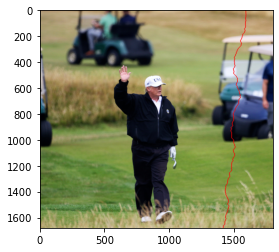

In [265]:
donald_plays_golf_1 = cv.imread('donald_plays_golf_1.png')
donald_plays_golf_1 = cv.cvtColor(donald_plays_golf_1, cv.COLOR_BGR2RGB)

mask = mask_list[0]
pixel_list = []
for i in range (mask.shape[0]):
    for j in range (mask.shape[1]):
        if mask[i,j,0] == False:
            pixel_list.append((i,j))
            
for el in pixel_list:
    donald_plays_golf_1[el[0],el[1]] = [255,0,0] 
    donald_plays_golf_1[el[0],el[1]-1] = [255,0,0]
    donald_plays_golf_1[el[0],el[1]+1] = [255,0,0]
    donald_plays_golf_1[el[0],el[1]+2] = [255,0,0]
    donald_plays_golf_1[el[0],el[1]-2] = [255,0,0]
      
plt.imshow(donald_plays_golf_1)

In [212]:
def remove_seams(img,mask_list, seam_dir):
    if seam_dir =='vertical':
        img_list = []
        for i in range(len(mask_list)):
            img = img[mask_list[i]].reshape((img.shape[0], img.shape[1]-1, 3))
            img_list.append(img)
    elif seam_dir =='horizental':
        img_list = []
        for i in range(len(mask_list)):
            img = np.rot90(img, 1, (0, 1))
            img = img[mask_list[i]].reshape((img.shape[0],img.shape[1]-1, 3))
            img = np.rot90(img, 3, (0, 1))
            img_list.append(img)
            
    return img_list

In [196]:
img_list = remove_seams(donald_plays_golf_1,mask_list, 'vertical')

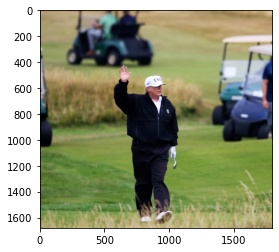

In [197]:
plt.imshow(img_list[4])

In [204]:
print(img_list[4].shape)

(1680, 1795, 3)


In [258]:
mask_list,seam_matrix = find_seams_list(donald_plays_golf_1,'horizental',5)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in ubyte_scalars


In [218]:
donald_plays_golf_1 = cv.imread('donald_plays_golf_1.png')
donald_plays_golf_1 = cv.cvtColor(donald_plays_golf_1, cv.COLOR_BGR2RGB)
img_list = remove_seams(donald_plays_golf_1,mask_list, 'horizental')

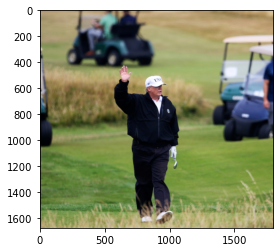

In [219]:
plt.imshow(img_list[4])

In [221]:
print(img_list[4].shape)

(1675, 1800, 3)


# as we seen it is working for num_seam = 5 but when we change this parameter to 180 it takes very long time to respond 

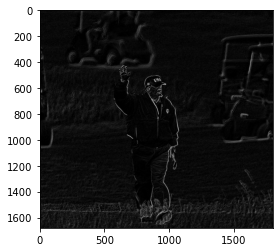

In [223]:
plt.imshow(find_energy_map(donald_plays_golf_1),cmap='gray')

In [225]:
seam = seam_matrix[0]

In [249]:
donald_plays_golf_1 = cv.imread('donald_plays_golf_1.png')
donald_plays_golf_1 = cv.cvtColor(donald_plays_golf_1, cv.COLOR_BGR2RGB)

mask = mask_list[0]
pixel_list = []
for i in range (mask.shape[0]):
    for j in range (mask.shape[1]):
        if mask[i,j,0] == False:
            pixel_list.append((i,j))
            
for el in pixel_list:
    donald_plays_golf_1[el[0],el[1]] = [255,0,0] 
    donald_plays_golf_1[el[0]-1,el[1]] = [255,0,0]
    donald_plays_golf_1[el[0]+1,el[1]] = [255,0,0]
    donald_plays_golf_1[el[0]+2,el[1]] = [255,0,0]
    donald_plays_golf_1[el[0]-2,el[1]] = [255,0,0]
    
plt.imshow(donald_plays_golf_1)

In [250]:
donald_plays_golf_1_ro = np.rot90(donald_plays_golf_1, 1, (0, 1))

In [248]:
mask = mask_list[0]
pixel_list = []
for i in range (mask.shape[0]):
    for j in range (mask.shape[1]):
        if mask[i,j,0] == False:
            pixel_list.append((i,j))

In [256]:
for el in pixel_list:
    donald_plays_golf_1_ro[el[0],el[1]] = [255,0,0] 
    donald_plays_golf_1_ro[el[0],el[1]-1] = [255,0,0]
    donald_plays_golf_1_ro[el[0],el[1]+1] = [255,0,0]
    donald_plays_golf_1_ro[el[0],el[1]+2] = [255,0,0]
    donald_plays_golf_1_ro[el[0],el[1]-2] = [255,0,0]

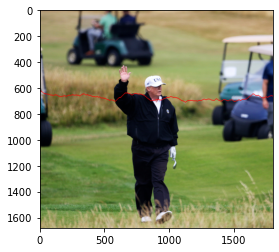

In [257]:
donald_plays_golf_1 = np.rot90(donald_plays_golf_1_ro, 3, (0, 1))
plt.imshow(donald_plays_golf_1)